# New *Zillow Price Zestimate*

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
import tarfile
import seaborn as sns  
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn import preprocessing

**unzip**/untar

In [ ]:
tar_gz_file = "/content/drive/MyDrive/Colab Notebooks/zillow.tar.gz"

In [ ]:
with tarfile.open(tar_gz_file, "r:gz") as tar:
  tar.extractall()

Load in csv in dataframe

In [ ]:
df1 = pd.read_csv("/content/zillow/properties_2016.csv")
df2 = pd.read_csv("/content/zillow/properties_2017.csv")

df_prop1 = pd.read_csv("/content/zillow/train_2016.csv")
df_prop2 = pd.read_csv("/content/zillow/train_2017.csv")

num_cols_df1 = df1.shape[1]
num_cols_df2 = df2.shape[1]



/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Looking at the data

In [ ]:
print("Number of rows in train 2016:", len(df1))
print("Number of rows in train 2017", len(df2))
print("Number of columns of cols:", num_cols_df1)
print("Number of columns of cols:", num_cols_df2)
print("Number of rows in prop 2016:", len(df_prop1))
print("Number of rows in prop 2017", len(df_prop2))
print("Number of columns of cols:", df_prop1.shape[1])
print("Number of columns of cols:", df_prop2.shape[1])

Number of rows in train 2016: 2985217
Number of rows in train 2017 2985217
Number of columns of cols: 58
Number of columns of cols: 58
Number of rows in prop 2016: 90275
Number of rows in prop 2017 77613
Number of columns of cols: 3
Number of columns of cols: 3


Data Preprocessing

In [ ]:
#combine train data from 2016 and 2017
df = pd.concat([df1, df2])
print("all columns in trains dataset now:", df.shape[1])
#combine properties data from 2016 and 2017
df_prop = pd.concat([df_prop1, df_prop2])
#no need to include the date
df_prop.drop('transactiondate', inplace = True, axis=1)
print("properties has  ", len(df_prop), "rows")
print("train has ", len(df), "rows")

all columns in trains dataset now: 58
properties has   167888 rows
train has  5970434 rows


In [ ]:
#remove duplicates
df = df.drop_duplicates(subset=['parcelid'])
df_prop = df_prop.drop_duplicates(subset=['parcelid'])
print("properties has  ", len(df_prop), "items/rows")
print("train set has ", len(df), "items/rows")

properties has   165210 items/rows
train set has  2985217 items/rows


In [ ]:
#Merging Data frames
df_prop = df_prop[df_prop.parcelid.isin(df.parcelid)]
print("Before Merge: rows in df={}, rows in df_prop={}".format(len(df), len(df_prop)))
df = pd.merge(df, df_prop, on='parcelid', how='inner')
print("After Merge: rows={}, columns={}".format(len(df), len(df.columns)))

Before Merge: rows in df=2985217, rows in df_prop=165210
After Merge: rows=165210, columns=59


Calulating the null count

In [ ]:
null_percentages = df.isnull().mean() * 100
null_percentages = null_percentages.reset_index()
null_percentages = null_percentages.rename(columns={"index": "Column", 0: "Null Percentage"})
null_percentages = null_percentages.sort_values(by="Null Percentage", ascending=False)

Data Visulaization

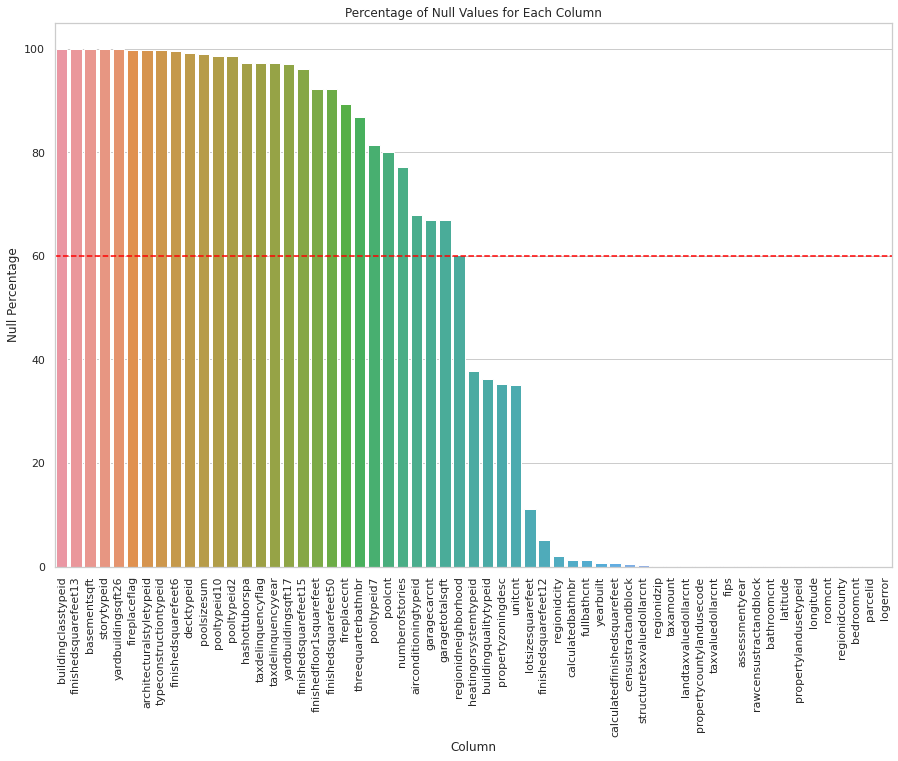

In [ ]:
# Visualize a scatter plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
# Create a horizontal line at y=60
plt.axhline(y=60, color='red', linestyle='--')
ax = sns.barplot(x="Column", y="Null Percentage", data=null_percentages)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Percentage of Null Values for Each Column")
plt.xlabel("Column")
plt.ylabel("Null Percentage")
plt.show()

Columns having more than 60% null values

In [ ]:
all_cols = null_percentages.values.tolist()
useless_cols = [i[0] for i in all_cols if i[1] > 60]
print("total columns = ",df.shape[1])
print("useless columns = ",len(useless_cols))

total columns =  59
useless columns =  29



Remove the Columns having more than 60% null values

NULL Elmination or NULL Replacement

dropping the useless columns


In [ ]:
for cols in useless_cols:
  df.drop(cols, inplace = True, axis=1)
print("Number of columns now ",len(df.columns))

Filling the Null Values

In [ ]:
df.columns
df.fillna(df.mean(), inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
print("Number of elemnts in the data frame are", len(df))


Number of columns 30
Number of elemnts in the data frame are 165210


<ipython-input-15-67208c26e3f8>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


Encoding the Labels for having numerica values

In [ ]:
le = preprocessing.LabelEncoder()
df['propertycountylandusecode'] = le.fit_transform(df['propertycountylandusecode'])
df['propertyzoningdesc'] = le.fit_transform(df['propertyzoningdesc'])

In [ ]:
# Convert the DataFrame to float128
df = df.astype('float128')
string_cols = df.select_dtypes(include=['object']).columns
le = preprocessing.LabelEncoder()
for col in string_cols:
    df[col] = le.fit_transform(df[col])


# Split the data into a training set (49%) and a test set (51%)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop("logerror", axis=1), df["logerror"], test_size=0.51, random_state=0)

# Divide the data into training and test sets
X = df.drop('logerror', axis=1)
y = df['logerror']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.51, random_state=0)



# Choose and fit a model
1. linear regression model

In [ ]:
# Create a linear regression model
lr = LinearRegression()

In [ ]:
# Fit the model to the training data
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Make predictions on train and test data
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Calculate mean absolute error for train and test data
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print the results
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train MAE: 0.06887212315256794424
Test MAE: 0.069269265384183227865


2. Lasso regression model

In [ ]:
regressor = Lasso(alpha=1.0)

In [ ]:
# Fit the model to the training data
regressor.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.200e+02, tolerance: 2.155e-01
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [ ]:
# Make predictions on train and test data
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculate mean absolute error for train and test data
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print the results
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train MAE: 0.06878425884236014599
Test MAE: 0.06915211122029712193


3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
# Create a Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

print("Random Forest Regression MAE:", mae)

Random Forest Regression MAE: 0.07505782316218388958
